In [3]:
import venn
from matplotlib.colors import to_rgba
import importlib
import matplotlib
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.diffmet_results import Results

In [11]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs(module_config.reference)
m5_path = {s: module_config.meth5_template_file_RANDOMIZED.format(sample=s) for s in ["HG003", "HG004"]}
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/pycometh/samplecomp/all_results_cache_RANDOMIZED.pkl"
real_results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/pycometh/samplecomp/all_results_cache.pkl"
load_from_cache=True


In [ ]:
with open(real_results_cache_file, "rb") as f:
        real_results = pickle.load(f)

In [12]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    basedir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/")

    if caller == "methcp":
        return basedir.joinpath("bs/mock_bsseq_from_nanopore/parents_mockbsseq_segments_methcp_diffmet_randomized.tsv")

    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        basedir = basedir.joinpath("pycometh","samplecomp_randomized", "cpg", "diffmet")
        fn = f"diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
    else:
        basedir = basedir.joinpath("pycometh", f"samplecomp_{segmentation}_randomized", "cpg", "diffmet")
        fn = f"diffmet_hyp_{test}_{ihw}.tsv"

    return basedir.joinpath(fn)

def get_all_result_files():
    #yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  [("PycoMeth", "pycometh")]:
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 600)}
                    #yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 20, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}


In [13]:
if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, m5_path, include_chroms={"20"}, read_group_key=None, samples=["HG003", "HG004"])


In [15]:
for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

Loading PycoMeth BS Diff (IHW) coarse
Filtering chromosomes
Annotating CpGs for PycoMeth BS Diff (IHW) coarse
Loading diffmet for PycoMeth BS Diff (IHW) coarse (2281 segments)
Finished loading PycoMeth BS Diff (IHW) coarse (2281 segments)
Loading PycoMeth LLR-Diff (IHW) coarse
Filtering chromosomes
Annotating CpGs for PycoMeth LLR-Diff (IHW) coarse
Loading diffmet for PycoMeth LLR-Diff (IHW) coarse (3200 segments)
Finished loading PycoMeth LLR-Diff (IHW) coarse (3200 segments)
Loading PycoMeth Fisher-E (IHW) coarse
Filtering chromosomes
Annotating CpGs for PycoMeth Fisher-E (IHW) coarse
Loading diffmet for PycoMeth Fisher-E (IHW) coarse (2986 segments)
Finished loading PycoMeth Fisher-E (IHW) coarse (2986 segments)
Loading PycoMeth BS Diff coarse
Filtering chromosomes
Annotating CpGs for PycoMeth BS Diff coarse
Loading diffmet for PycoMeth BS Diff coarse (2374 segments)
Finished loading PycoMeth BS Diff coarse (2374 segments)
Loading PycoMeth LLR-Diff coarse
Filtering chromosomes
Annot

In [16]:
del results.reference_cpgs.ref
with open(results_cache_file, "bw") as f:
    pickle.dump(results, f)

In [17]:
results.colors = {}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"
    else:
        results.patterns[key] = ""

In [49]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1, min_segment_calls=0, additional_index=None, results=results):
    segments = results.segments[key]
    if additional_index is not None:
        segments = segments.loc[additional_index]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    segments = segments.loc[segments["n_calls"].map(lambda x: x >= min_segment_calls)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

def plot_bar_diffmetcolored(x, key, diffmet_thresholds = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0], cmap="jet"):
    cmap = matplotlib.cm.get_cmap(cmap)
    last_thres = diffmet_thresholds[0]
    diffmet_thresholds = diffmet_thresholds[1:]
    left = 0
    segments = results.segments[key]
    for thres in diffmet_thresholds:
        color = cmap((thres+last_thres)/2)
        idx = segments["diffmet"].map(lambda x: last_thres < abs(x) <= thres)
        n = get_num_dmr_cpgs(key, additional_index=idx, min_diff=0.01)
        plt.barh(x, n, left=left, color=color)
        left += n
        last_thres = thres

0.1|PycoMeth LLR-Diff coarse|666639
0.2|PycoMeth LLR-Diff coarse|9385
0.3|PycoMeth LLR-Diff coarse|675
0.4|PycoMeth LLR-Diff coarse|245
0.6|PycoMeth LLR-Diff coarse|128
0.8|PycoMeth LLR-Diff coarse|20
1.0|PycoMeth LLR-Diff coarse|0
0.1|PycoMeth LLR-Diff (IHW) coarse|661051
0.2|PycoMeth LLR-Diff (IHW) coarse|9294
0.3|PycoMeth LLR-Diff (IHW) coarse|699
0.4|PycoMeth LLR-Diff (IHW) coarse|264
0.6|PycoMeth LLR-Diff (IHW) coarse|128
0.8|PycoMeth LLR-Diff (IHW) coarse|20
1.0|PycoMeth LLR-Diff (IHW) coarse|0
0.1|PycoMeth BS Diff coarse|562119
0.2|PycoMeth BS Diff coarse|5080
0.3|PycoMeth BS Diff coarse|528
0.4|PycoMeth BS Diff coarse|43
0.6|PycoMeth BS Diff coarse|10
0.8|PycoMeth BS Diff coarse|0
1.0|PycoMeth BS Diff coarse|0
0.1|PycoMeth BS Diff (IHW) coarse|544095
0.2|PycoMeth BS Diff (IHW) coarse|5167
0.3|PycoMeth BS Diff (IHW) coarse|547
0.4|PycoMeth BS Diff (IHW) coarse|43
0.6|PycoMeth BS Diff (IHW) coarse|10
0.8|PycoMeth BS Diff (IHW) coarse|0
1.0|PycoMeth BS Diff (IHW) coarse|0
0.1|Pyco

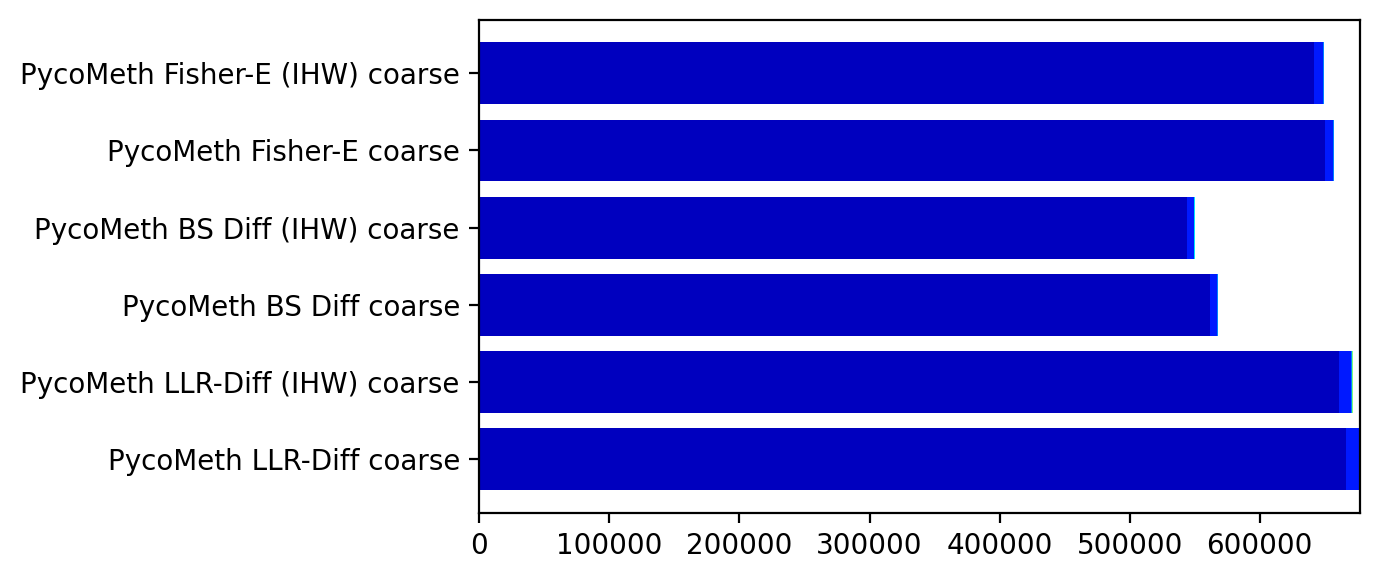

In [49]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_fisher_ihw_RANDOMIZED"):
    tools = ['PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E coarse', 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff coarse', 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff coarse'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()



In [55]:
def plot_venn(filename, tools, colors=None):
    if colors is not None:
        venn._venn.generate_colors = lambda *args, **kwargs: [to_rgba(colors[k], alpha=0.5) for k in tools]
    else:
        importlib.reload(venn)
    cgs_for_venn = {tool: unions(get_dmrs(tool, min_diff=0.1)["CpGs"]) for tool in tools}
    pa.figure()
    venn.venn(cgs_for_venn, fmt="{percentage:.1f}%")
    pa.saveandshow(filename)

<Figure size 1200x800 with 0 Axes>

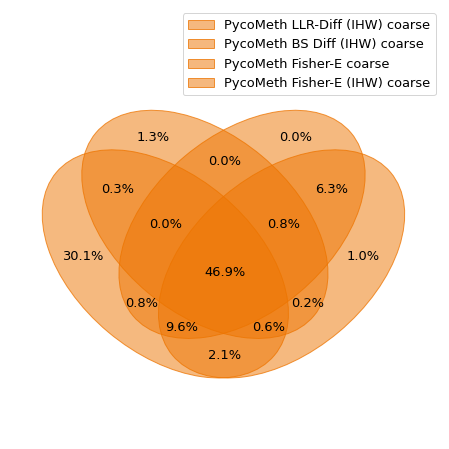

In [57]:
plot_venn("giab_parents_venn_tests_RANDOMIZED",  ['PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E coarse', 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth LLR-Diff (IHW) coarse', ][::-1])

PycoMeth LLR-Diff coarse 0.01 1.666927627643153
PycoMeth LLR-Diff coarse 0.02 1.7625358110117884
PycoMeth LLR-Diff coarse 0.03 1.8377044772230184
PycoMeth LLR-Diff coarse 0.04 1.7402209562253215
PycoMeth LLR-Diff coarse 0.05 1.2754211423860855
PycoMeth LLR-Diff coarse 0.060000000000000005 0.5962839003519426
PycoMeth LLR-Diff coarse 0.06999999999999999 0.22334641572381217
PycoMeth LLR-Diff coarse 0.08 0.1117868468096192
PycoMeth LLR-Diff coarse 0.09 0.07922989296307441
PycoMeth LLR-Diff coarse 0.09999999999999999 0.06835332121418203
PycoMeth LLR-Diff coarse 0.11 0.06590478350315067
PycoMeth LLR-Diff coarse 0.12 0.07193546430521017
PycoMeth LLR-Diff coarse 0.13 0.08214845891939454
PycoMeth LLR-Diff coarse 0.14 0.09423352077995541
PycoMeth LLR-Diff coarse 0.15000000000000002 0.046310506449873494
PycoMeth LLR-Diff coarse 0.16 0.052980485077607095
PycoMeth LLR-Diff coarse 0.17 0.05741253051261188
PycoMeth LLR-Diff coarse 0.18000000000000002 0.0588570730316484
PycoMeth LLR-Diff coarse 0.19 0

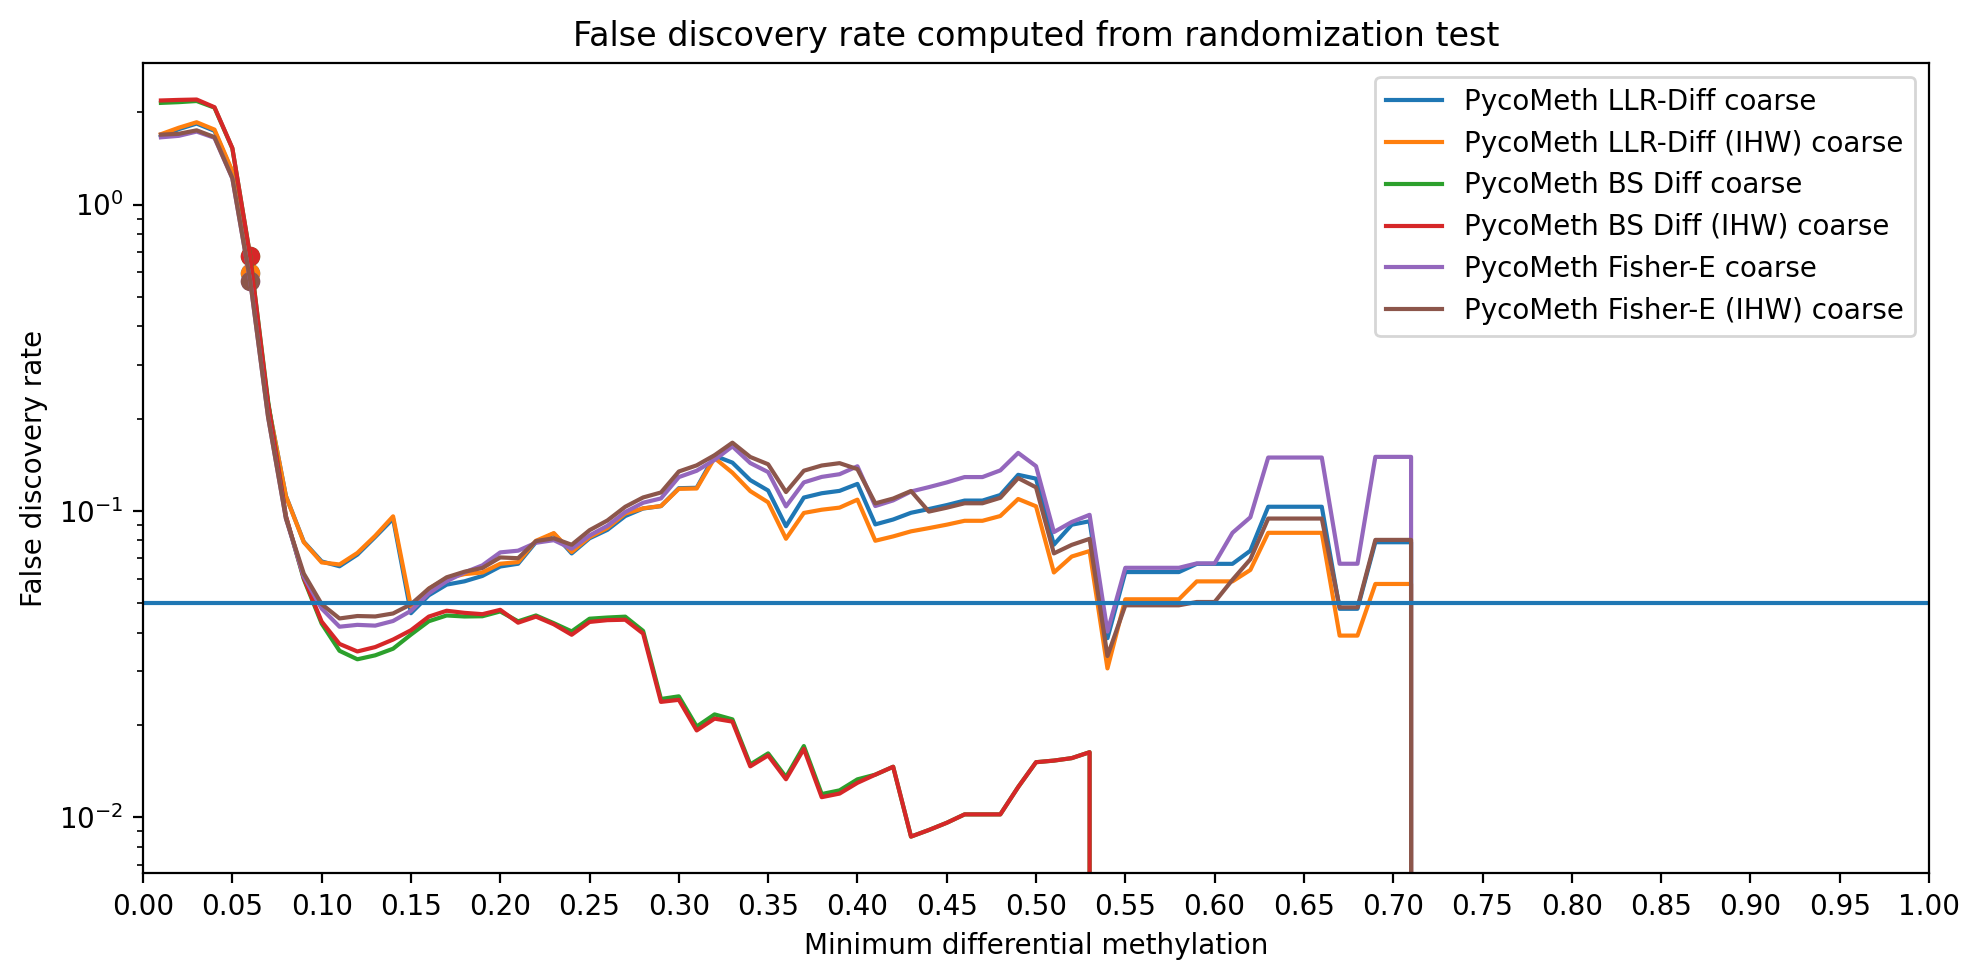

In [44]:
pa.figure(figsize=(10,5))
tools = ['PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E coarse', 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff coarse', 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff coarse'][::-1]
for tool in tools:
    segments = results.segments[tool]
    real_segments = real_results.segments[tool]
    fdrs = []
    thresholds = []
    for thres in np.arange(0.01, 1, 0.01):
        n = get_num_dmr_cpgs(tool, results=results,min_diff=thres)
        real_n = get_num_dmr_cpgs(tool, results=real_results, min_diff=thres)
        if real_n == 0:
            if n == 0:
                fdr = 0
            else:
                fdr = 1
        else:
            fdr = n/real_n
        fdrs.append(fdr)
        print(tool, thres, fdr)
        thresholds.append(thres)
    plt.plot(thresholds, fdrs, label=tool)
    plt.scatter(thresholds[5], fdrs[5])
plt.yscale("log")
plt.xticks(np.arange(0, 1.1, 0.05))
plt.xlabel("Minimum differential methylation")
plt.ylabel("False discovery rate")
plt.title("False discovery rate computed from randomization test")
plt.hlines(0.05, 0, 1)
plt.xlim(0,1)
plt.legend()
pa.saveandshow("randomization_test_fdr_diffmet_thres")

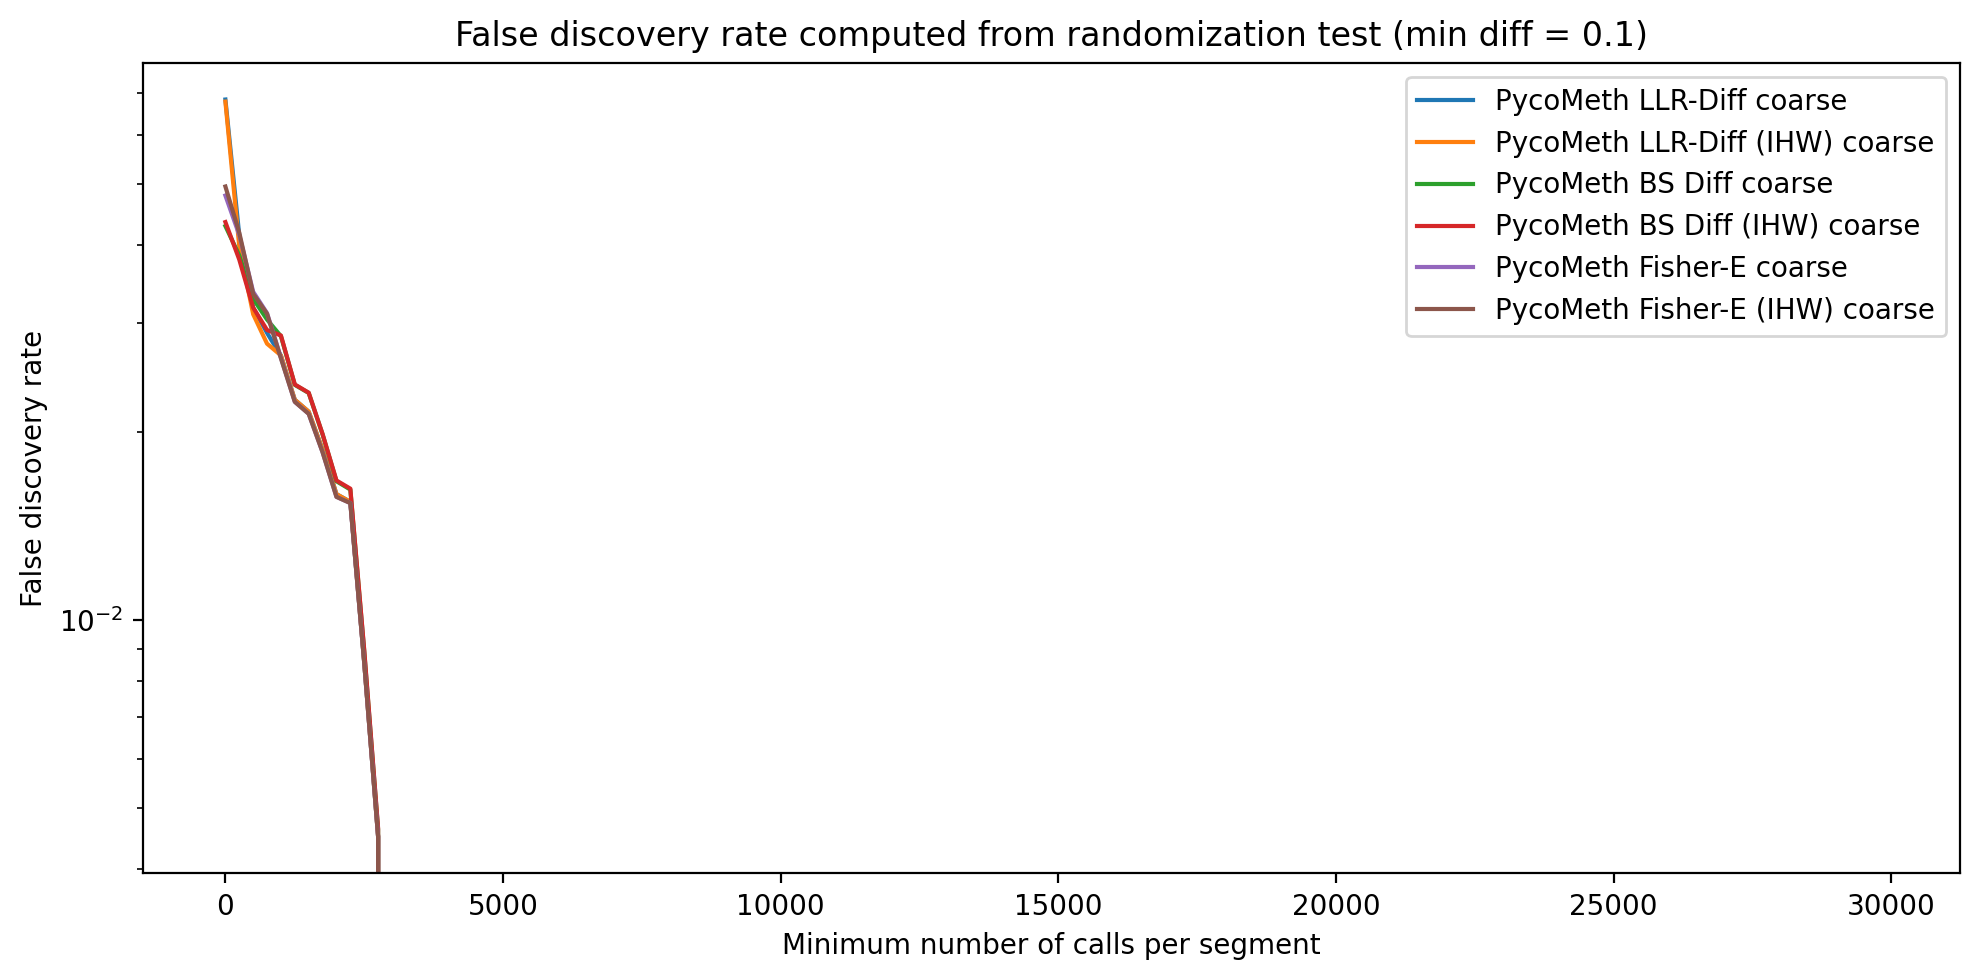

In [84]:
pa.figure(figsize=(10,5))
tools = ['PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E coarse', 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff coarse', 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff coarse'][::-1]
min_diff = 0.1
for tool in tools:
    segments = results.segments[tool]
    real_segments = real_results.segments[tool]
    last_thres = 0.01
    fdrs = []
    thresholds = np.arange(0, 30000, 250)
    for thres in thresholds:
        n = get_num_dmr_cpgs(tool, results=results, min_diff=min_diff, min_segment_calls=thres)
        real_n = get_num_dmr_cpgs(tool, results=real_results, min_diff=min_diff, min_segment_calls=thres)
        if real_n == 0:
            if n == 0:
                fdr = 0
            else:
                fdr = 1
        else:
            fdr = n/real_n
        fdrs.append(fdr)
        last_thres = thres
    plt.yscale("log")
    plt.plot(thresholds, fdrs, label=tool)
plt.xlabel("Minimum number of calls per segment")
plt.ylabel("False discovery rate")
plt.title(f"False discovery rate computed from randomization test (min diff = {min_diff})")
plt.legend()
pa.saveandshow("randomization_test_fdr_numcalls_thres")

In [ ]:
results.segments['PycoMeth BS Diff (IHW) coarse']["n_calls"]

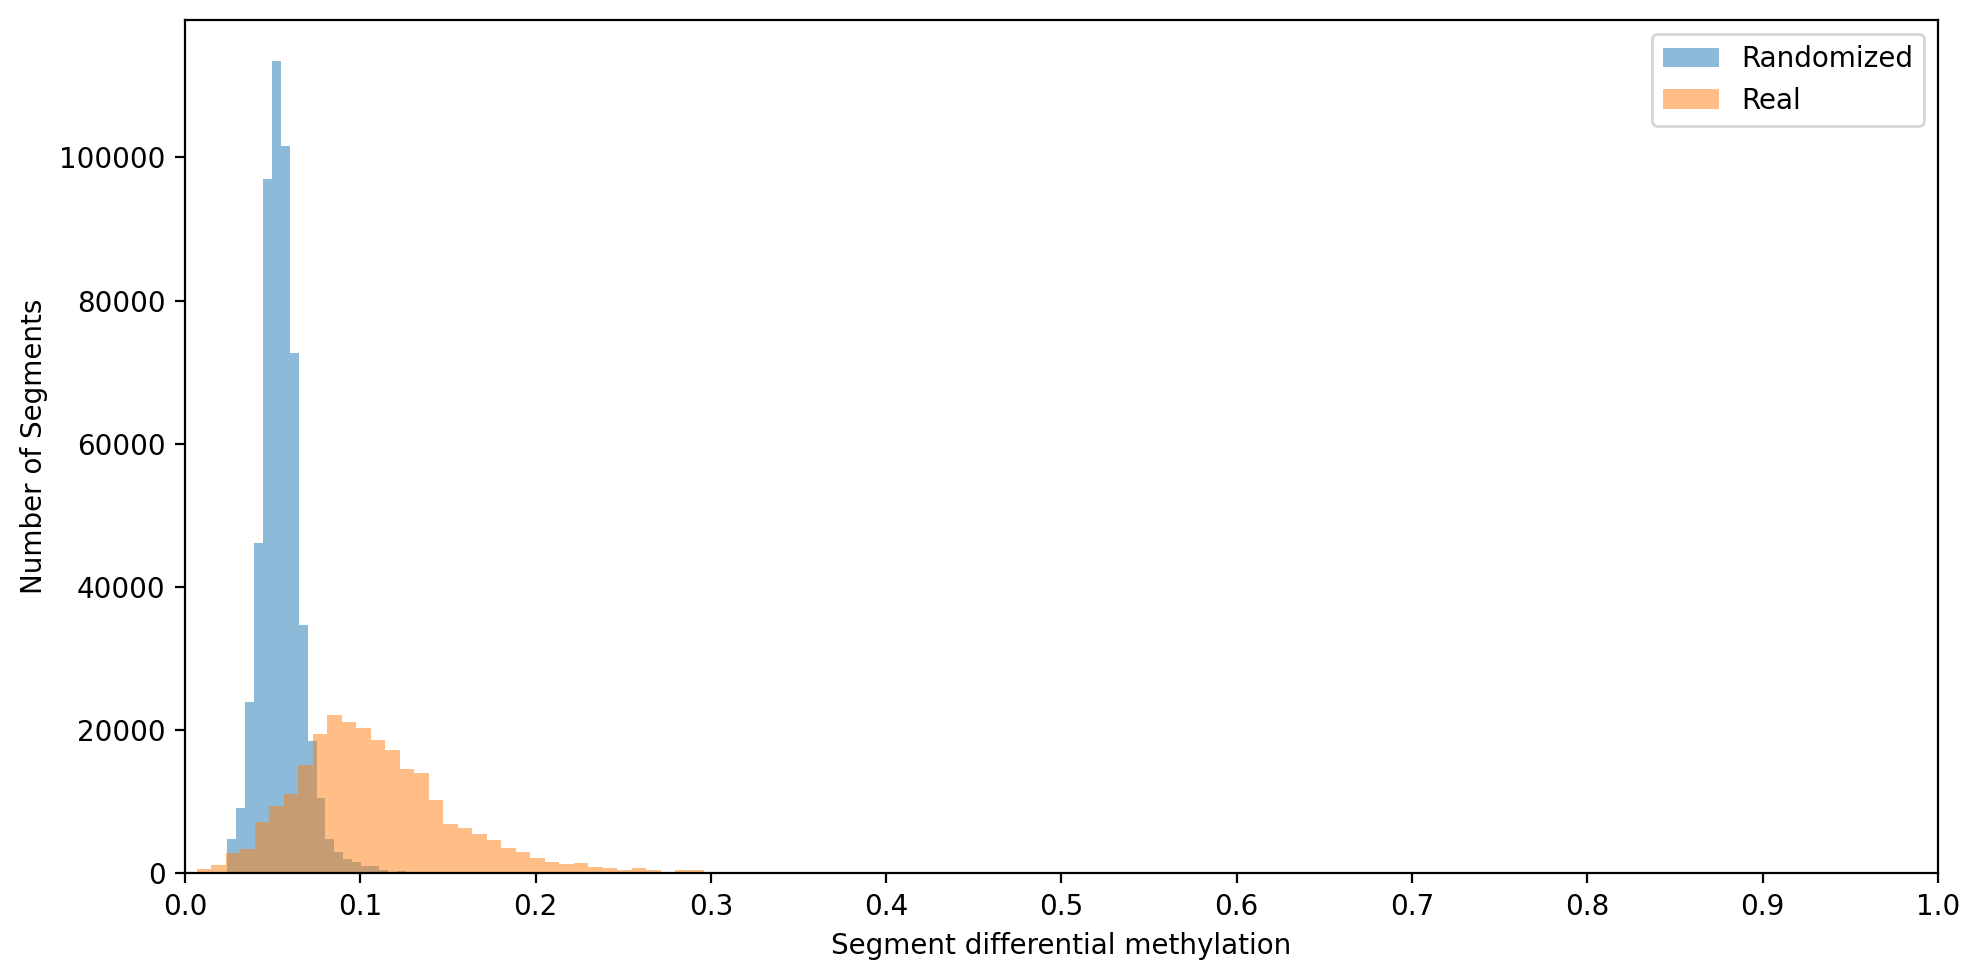

In [96]:
diffmet_dist  = [row["diffmet"] for _, row in results.segments['PycoMeth BS Diff (IHW) coarse'].iterrows() for cpg in row["CpGs"] ]
real_diffmet_dist  = [row["diffmet"] for _, row in real_results.segments['PycoMeth BS Diff (IHW) coarse'].iterrows() for cpg in row["CpGs"] ]

pa.figure(figsize=(10,5))
plt.hist(diffmet_dist, bins=100, alpha=0.5, label="Randomized")
plt.hist(real_diffmet_dist, bins=100, alpha=0.5, label="Real")
plt.xlabel("Segment differential methylation")
plt.ylabel("Number of CpGs")
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend()
pa.saveandshow("randomization_test_diffmet_distribution")

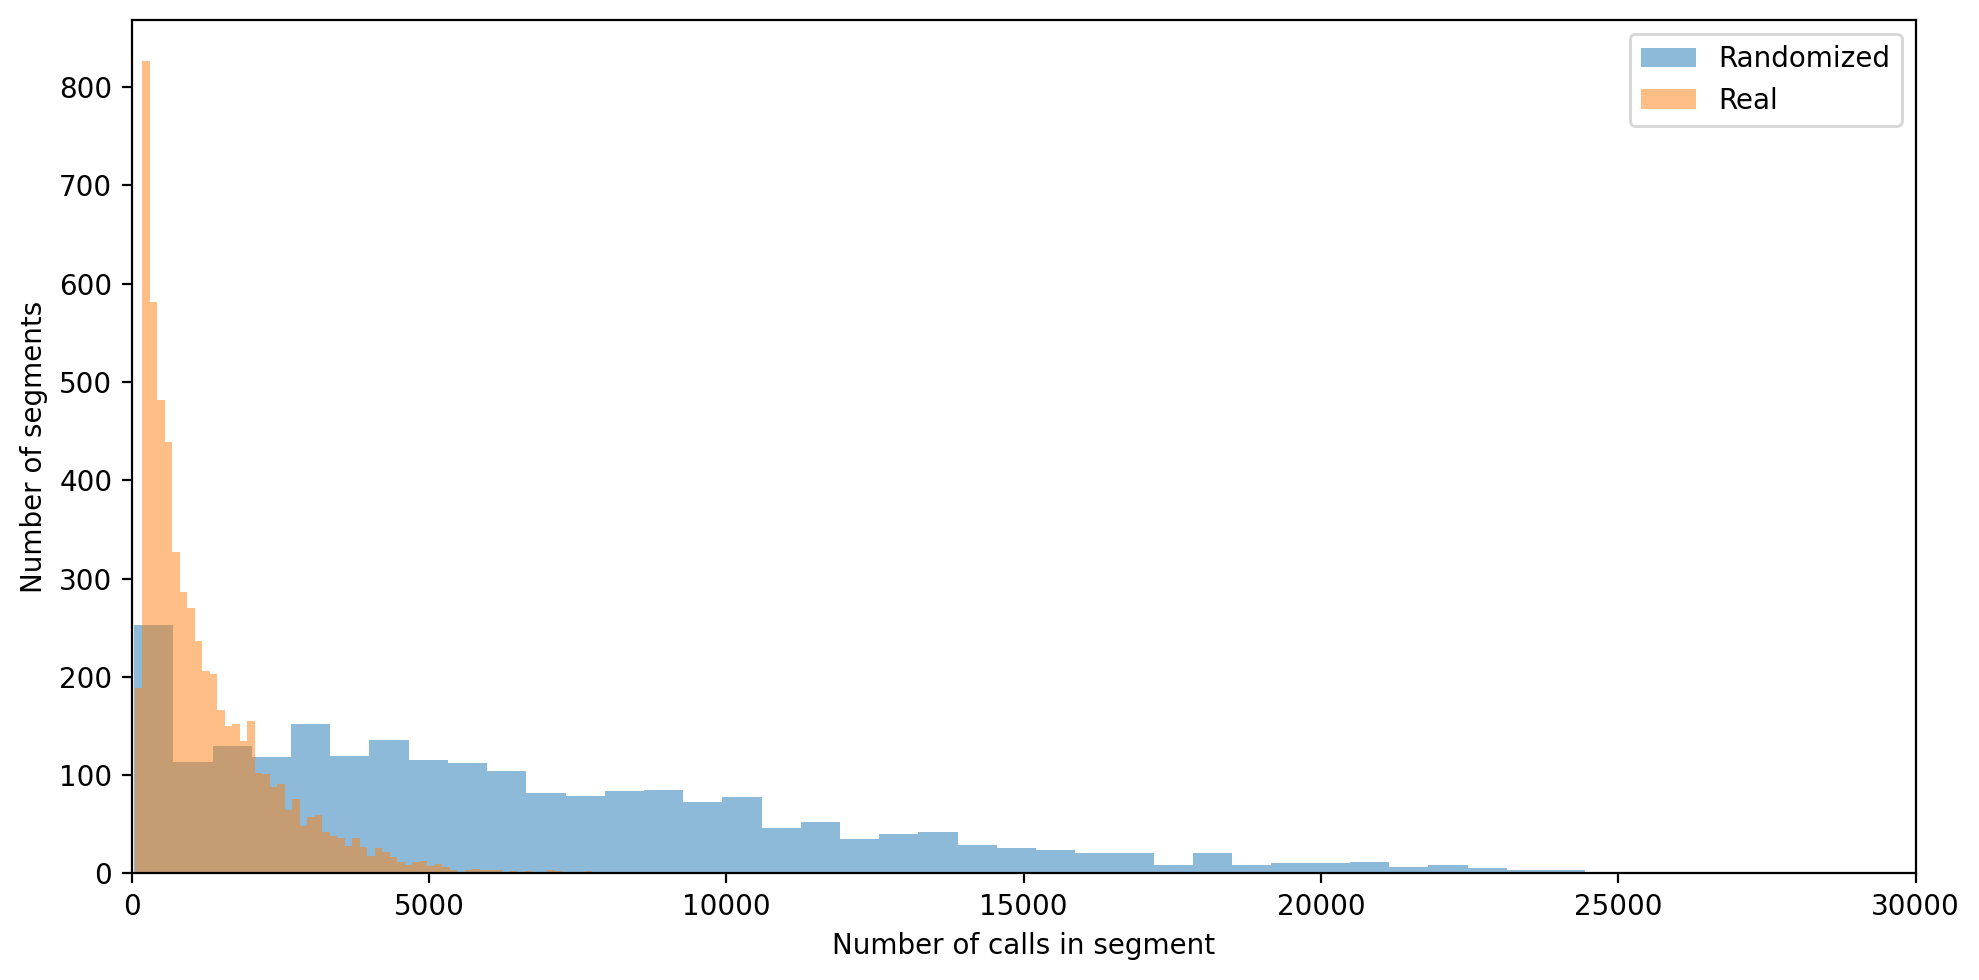

In [69]:
ncalls_dist  = [row["n_calls"] for _, row in results.segments['PycoMeth BS Diff (IHW) coarse'].iterrows()]
real_ncalls_dist  = [row["n_calls"] for _, row in real_results.segments['PycoMeth BS Diff (IHW) coarse'].iterrows() ]

pa.figure(figsize=(10,5))
plt.hist(ncalls_dist, bins=100, alpha=0.5, label="Randomized")
plt.hist(real_ncalls_dist, bins=100, alpha=0.5, label="Real")
plt.xlabel("Number of calls in segment")
plt.ylabel("Number of segments")
plt.legend()
plt.xlim(0, 30000)
pa.saveandshow("randomization_test_numcalls_distribution")